# Analysis of Classification Models in Letter Recognition
### by Joshua Gabella
_______________________________________________________________________________________________________________________________


Imports

In [672]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
import time

In [673]:
df = pd.read_csv("letter-recognition.data", index_col=False)
data = df.to_numpy()
HKdata = data[np.logical_or(data[:,0]=='H', data[:,0] == 'K'), :]
MYdata = data[np.logical_or(data[:,0]=='M', data[:,0] == 'Y'), :]
DOdata = data[np.logical_or(data[:,0]=='D', data[:,0] == 'O'), :]

## Optional Dimensionality Reduction
Set DRType to 'VarianceThreshold' or 'PCA' for a specific Dimensionality Reduction

In [674]:
#PCAnalysis
DRType = 'PCA'
def runPCA(data):
    training_data, test_data = train_test_split(HKdata, test_size=0.1, random_state=0)
    training_y = training_data[:, 0]
    training_X = training_data[:, 1:]
    test_y = test_data[:, 0]
    test_X = test_data[:, 1:]
    scaler = StandardScaler()
    scaler.fit(training_X)
    Xtr = scaler.transform(training_X)
    Xtest = scaler.transform(test_X)
    
    pca=PCA()
    pca.fit_transform(Xtr)
    varex = pca.explained_variance_

    plt.bar(range(len(varex)), varex, alpha = 0.5, label="HK Data") #have to hardcode data label
    plt.legend()
    plt.ylabel('Variance Ratio')
    plt.xlabel('Principal Components')
    plt.show()

def processData(data, reduce_dim=False, method='PCA'):
    features = data[:, 1:]
    labels = data[:, 0]
    if reduce_dim:
        if method=='PCA':
            scaler = StandardScaler()
            features = scaler.fit_transform(features)
            pca=PCA(n_components=4)
            features = pca.fit_transform(features)
            data = np.hstack((labels.reshape(len(features), 1), features))
        elif method=='VarianceThreshold':
            vars = []
            for col in features.T:
                vars.append(np.var(col))
            vars = np.flip(np.sort(np.array(vars)))
            selector = VarianceThreshold(threshold=(vars[3]+vars[4])/2)
            selector.fit(features)
            features = selector.transform(features)
            data = np.hstack((labels.reshape(len(features), 1), features))
        else:
            data = None
    else:
        data = np.hstack((labels.reshape(len(features), 1), features))
    return data
    
# runPCA(HKdata)
# DRType = 'VarianceThreshold'
# HKdata, MYdata, DOdata = processData(data, True, DRType)


## H and K Analysis
Comment out the first two lines in the cell below to avoid any dimensionality reduction. Otherwise set the second field of processData()
to False

In [675]:
# DRTypeHK = DRType
# HKdata = processData(HKdata, True, DRTypeHK)
training_data, test_data = train_test_split(HKdata, test_size=0.1, random_state=0)
training_y_HK = training_data[:, 0]
training_X_HK = training_data[:, 1:]
test_y_HK = test_data[:, 0]
test_X_HK = test_data[:, 1:]

### Kernel SVM - H/K

In [676]:
clf = GridSearchCV(svm.SVC(), {
    'C':[0.1, 1, 5, 10, 20],
    'kernel':['rbf', 'linear', 'sigmoid'],
    'gamma':['auto', 'scale']
}, cv=5)
clf.fit(training_X_HK, training_y_HK)
param_SVM_resultsHK = pd.DataFrame(clf.cv_results_)
trimmed_SVM_resultsHK = param_SVM_resultsHK[['param_C', 'param_kernel', 'param_gamma', 'mean_test_score', 'std_test_score']]



In [677]:
trimmed_SVM_resultsHK.sort_values('mean_test_score', ascending=False)

,param_C,param_kernel,param_gamma,mean_test_score,std_test_score
12,5,rbf,auto,0.911698,0.013202
18,10,rbf,auto,0.910189,0.012493
6,1,rbf,auto,0.903396,0.014439
24,20,rbf,auto,0.902642,0.012028
27,20,rbf,scale,0.889057,0.015019
0,0.1,rbf,auto,0.882264,0.016774
15,5,rbf,scale,0.878491,0.017764
21,10,rbf,scale,0.877736,0.014439
9,1,rbf,scale,0.858113,0.019330
3,0.1,rbf,scale,0.789434,0.024502


---
### Decision Tree Classifier - H/K

In [678]:
clf = GridSearchCV(tree.DecisionTreeClassifier(), {
    'criterion':['gini', 'entropy'],
    'max_depth':[2, 5, 10, 20, 50]
}, cv=5)
clf.fit(training_X_HK, training_y_HK)
param_tree_resultsHK = pd.DataFrame(clf.cv_results_)
trimmed_tree_resultsHK = param_tree_resultsHK[['param_criterion', 'param_max_depth', 'mean_test_score', 'std_test_score']]


In [679]:
trimmed_tree_resultsHK.sort_values('mean_test_score', ascending=False)

,param_criterion,param_max_depth,mean_test_score,std_test_score
8,entropy,20,0.894340,0.013710
9,entropy,50,0.892830,0.014828
4,gini,50,0.892075,0.019033
3,gini,20,0.891321,0.017924
2,gini,10,0.889057,0.014635
7,entropy,10,0.883774,0.022312
1,gini,5,0.864151,0.008605
6,entropy,5,0.854340,0.016116
0,gini,2,0.662642,0.025437
5,entropy,2,0.662642,0.025437


---
### Random Forest

In [680]:
clf = GridSearchCV(RandomForestClassifier(), {
    'criterion':['gini', 'entropy'],
    'max_depth':[2, 5, 10, 20, 50],
    'n_estimators':[10, 50, 100, 200, 500]
}, cv=5)
clf.fit(training_X_HK, training_y_HK)
param_forest_resultsHK = pd.DataFrame(clf.cv_results_)
trimmed_forest_resultsHK = param_forest_resultsHK[['param_n_estimators', 'param_criterion', 'param_max_depth', 'mean_test_score', 'std_test_score']]

In [681]:
trimmed_forest_resultsHK.sort_values('mean_test_score', ascending=False)

,param_n_estimators,param_criterion,param_max_depth,mean_test_score,std_test_score
38,200,entropy,10,0.906415,0.012941
36,50,entropy,10,0.906415,0.011296
39,500,entropy,10,0.905660,0.013501
17,100,gini,20,0.905660,0.009243
48,200,entropy,50,0.904906,0.012493
47,100,entropy,50,0.904906,0.009057
37,100,entropy,10,0.904906,0.015723
43,200,entropy,20,0.904906,0.009665
44,500,entropy,20,0.904906,0.010237
24,500,gini,50,0.904906,0.008736


---
### K-Nearest Neighbor - H/K

In [682]:
clf = GridSearchCV(KNeighborsClassifier(), {
    'algorithm':['ball_tree', 'brute', 'kd_tree'],
    'n_neighbors':[1, 3, 5, 10, 20],
    'weights': ['uniform', 'distance']
}, cv=5)
clf.fit(training_X_HK, training_y_HK)
param_knn_resultsHK = pd.DataFrame(clf.cv_results_)
trimmed_knn_resultsHK = param_knn_resultsHK[['param_n_neighbors', 'param_algorithm', 'param_weights', 'mean_test_score', 'std_test_score']]

In [683]:
trimmed_knn_resultsHK.sort_values('mean_test_score', ascending=False)

,param_n_neighbors,param_algorithm,param_weights,mean_test_score,std_test_score
14,5,brute,uniform,0.907170,0.018579
15,5,brute,distance,0.904151,0.011092
17,10,brute,distance,0.904151,0.012075
4,5,ball_tree,uniform,0.902642,0.017111
5,5,ball_tree,distance,0.902642,0.009366
7,10,ball_tree,distance,0.901887,0.011933
27,10,kd_tree,distance,0.901132,0.010512
23,3,kd_tree,distance,0.901132,0.011789
25,5,kd_tree,distance,0.900377,0.007770
10,1,brute,uniform,0.899623,0.009724


---
### Artifical Neural Network - H/K

In [684]:
clf = GridSearchCV(MLPClassifier(), {
    'hidden_layer_sizes' : [(20), (10, 15, 20, 15, 10), (10, 20, 10)],
    'activation':['identity', 'relu', 'logistic']
}, cv=5)
clf.fit(training_X_HK, training_y_HK)
param_ann_resultsHK = pd.DataFrame(clf.cv_results_)
trimmed_ann_resultsHK = param_ann_resultsHK[['param_activation', 'param_hidden_layer_sizes','mean_test_score', 'std_test_score']]

C:\Users\Joshua\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Joshua\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Joshua\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Joshua\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

In [685]:
trimmed_ann_resultsHK.sort_values('mean_test_score', ascending=False)

,param_activation,param_hidden_layer_sizes,mean_test_score,std_test_score
4,relu,"(10, 15, 20, 15, 10)",0.874717,0.030694
5,relu,"(10, 20, 10)",0.856604,0.016706
3,relu,20,0.795472,0.030879
8,logistic,"(10, 20, 10)",0.741132,0.031081
6,logistic,20,0.717736,0.044866
0,identity,20,0.689057,0.035206
2,identity,"(10, 20, 10)",0.688302,0.028097
1,identity,"(10, 15, 20, 15, 10)",0.673208,0.023578
7,logistic,"(10, 15, 20, 15, 10)",0.498868,0.001509


---
## M and Y Analysis
Comment out the first two lines in the cell below to avoid any dimensionality reduction. Otherwise set the second field of processData()
to False

In [686]:
# DRTypeMY = DRType
# MYdata = processData(MYdata, True, DRTypeMY)
training_data, test_data = train_test_split(MYdata, test_size=0.1, random_state=0)
training_y_MY = training_data[:, 0]
training_X_MY = training_data[:, 1:]
test_y_MY = test_data[:, 0]
test_X_MY = test_data[:, 1:]

---
### K-Nearest Neighbor - M/Y

In [687]:
clf = GridSearchCV(KNeighborsClassifier(), {
    'algorithm':['ball_tree', 'brute', 'kd_tree'],
    'n_neighbors':[1, 3, 5, 10, 20],
    'weights': ['uniform', 'distance']
}, cv=5)
clf.fit(training_X_MY, training_y_MY)
param_knn_resultsMY = pd.DataFrame(clf.cv_results_)
trimmed_knn_resultsMY = param_knn_resultsMY[['param_n_neighbors', 'param_algorithm', 'param_weights', 'mean_test_score', 'std_test_score']]
trimmed_knn_resultsMY.sort_values('mean_test_score', ascending=False)

,param_n_neighbors,param_algorithm,param_weights,mean_test_score,std_test_score
12,3,brute,uniform,0.985211,0.006828
24,5,kd_tree,uniform,0.984507,0.006900
13,3,brute,distance,0.983803,0.007250
2,3,ball_tree,uniform,0.983803,0.004776
4,5,ball_tree,uniform,0.983803,0.007250
5,5,ball_tree,distance,0.983803,0.007905
25,5,kd_tree,distance,0.983803,0.007905
22,3,kd_tree,uniform,0.983803,0.003591
3,3,ball_tree,distance,0.983099,0.005634
23,3,kd_tree,distance,0.982394,0.004980


---
### Decision Tree Classifier - M/Y

In [688]:
clf = GridSearchCV(tree.DecisionTreeClassifier(), {
    'criterion':['gini', 'entropy'],
    'max_depth':[2, 5, 10, 20, 50]
}, cv=5)
clf.fit(training_X_MY, training_y_MY)
param_tree_resultsMY = pd.DataFrame(clf.cv_results_)
trimmed_tree_resultsMY = param_tree_resultsMY[['param_criterion', 'param_max_depth', 'mean_test_score', 'std_test_score']]
# trimmed_tree_resultsMY.sort_values('mean_test_score', ascending=False)

---
### Random Forest - M/Y

In [689]:
clf = GridSearchCV(RandomForestClassifier(), {
    'criterion':['gini', 'entropy'],
    'max_depth':[2, 5, 10, 20, 50],
    'n_estimators':[10, 50, 100, 200, 500]
}, cv=5)
clf.fit(training_X_MY, training_y_MY)
param_forest_resultsMY = pd.DataFrame(clf.cv_results_)
trimmed_forest_resultsMY = param_forest_resultsMY[['param_n_estimators', 'param_criterion', 'param_max_depth', 'mean_test_score', 'std_test_score']]
# trimmed_forest_resultsMY.sort_values('mean_test_score', ascending=False)

---
### Kernel SVM - M/Y

In [690]:
clf = GridSearchCV(svm.SVC(), {
    'C':[0.1, 1, 5, 10, 20],
    'kernel':['rbf', 'linear', 'sigmoid'],
    'gamma':['auto', 'scale']
}, cv=5)
clf.fit(training_X_MY, training_y_MY)
param_SVM_resultsMY = pd.DataFrame(clf.cv_results_)
trimmed_SVM_resultsMY = param_SVM_resultsMY[['param_C', 'param_kernel', 'param_gamma', 'mean_test_score', 'std_test_score']]
# trimmed_SVM_resultsMY.sort_values('mean_test_score', ascending=False)

---
### Artifical Neural Network - M/Y

In [691]:
clf = GridSearchCV(MLPClassifier(), {
    'hidden_layer_sizes' : [(20), (10, 15, 20, 15, 10), (10, 20, 10)],
    'activation':['identity', 'relu', 'logistic']
}, cv=5)
clf.fit(training_X_MY, training_y_MY)
param_ann_resultsMY = pd.DataFrame(clf.cv_results_)
trimmed_ann_resultsMY = param_ann_resultsMY[['param_activation', 'param_hidden_layer_sizes','mean_test_score', 'std_test_score']]
# trimmed_ann_resultsMY.sort_values('mean_test_score', ascending=False)

C:\Users\Joshua\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Joshua\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Joshua\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Joshua\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

---
## D/O Analysis

In [692]:
# DRTypeDO = DRType
# DOdata = processData(DOdata, True, DRTypeDO)
training_data, test_data = train_test_split(DOdata, test_size=0.1, random_state=0)
training_y_DO = training_data[:, 0]
training_X_DO = training_data[:, 1:]
test_y_DO = test_data[:, 0]
test_X_DO = test_data[:, 1:]

---
### K-Nearest Neighbor - D/O

In [693]:
clf = GridSearchCV(KNeighborsClassifier(), {
    'algorithm':['ball_tree', 'brute', 'kd_tree'],
    'n_neighbors':[1, 3, 5, 10, 20],
    'weights': ['uniform', 'distance']
}, cv=5)
clf.fit(training_X_DO, training_y_DO)
param_knn_resultsDO = pd.DataFrame(clf.cv_results_)
trimmed_knn_resultsDO = param_knn_resultsDO[['param_n_neighbors', 'param_algorithm', 'param_weights', 'mean_test_score', 'std_test_score']]
trimmed_knn_resultsDO.sort_values('mean_test_score', ascending=False)

,param_n_neighbors,param_algorithm,param_weights,mean_test_score,std_test_score
13,3,brute,distance,0.840928,0.022853
17,10,brute,distance,0.835203,0.029283
27,10,kd_tree,distance,0.834499,0.029178
15,5,brute,distance,0.834494,0.032577
12,3,brute,uniform,0.833810,0.020130
7,10,ball_tree,distance,0.833787,0.027643
19,20,brute,distance,0.833782,0.026923
9,20,ball_tree,distance,0.831637,0.027214
29,20,kd_tree,distance,0.830923,0.028519
3,3,ball_tree,distance,0.830219,0.024218


---
### Decision Tree Classifier - D/O

In [694]:
clf = GridSearchCV(tree.DecisionTreeClassifier(), {
    'criterion':['gini', 'entropy'],
    'max_depth':[2, 5, 10, 20, 50]
}, cv=5)
clf.fit(training_X_DO, training_y_DO)
param_tree_resultsDO = pd.DataFrame(clf.cv_results_)
trimmed_tree_resultsDO = param_tree_resultsDO[['param_criterion', 'param_max_depth', 'mean_test_score', 'std_test_score']]
trimmed_tree_resultsDO.sort_values('mean_test_score', ascending=False)

,param_criterion,param_max_depth,mean_test_score,std_test_score
3,gini,20,0.840203,0.030439
4,gini,50,0.839492,0.030480
9,entropy,50,0.838775,0.030458
2,gini,10,0.838081,0.022249
8,entropy,20,0.838063,0.030961
7,entropy,10,0.835951,0.021988
1,gini,5,0.786007,0.014988
6,entropy,5,0.779586,0.023098
0,gini,2,0.762489,0.009005
5,entropy,2,0.748203,0.027277


---
### Random Forest - D/O

In [695]:
clf = GridSearchCV(RandomForestClassifier(), {
    'criterion':['gini', 'entropy'],
    'max_depth':[2, 5, 10, 20, 50],
    'n_estimators':[10, 50, 100, 200, 500]
}, cv=5)
clf.fit(training_X_DO, training_y_DO)
param_forest_resultsDO = pd.DataFrame(clf.cv_results_)
trimmed_forest_resultsDO = param_forest_resultsDO[['param_n_estimators', 'param_criterion', 'param_max_depth', 'mean_test_score', 'std_test_score']]
trimmed_forest_resultsDO.sort_values('mean_test_score', ascending=False)

,param_n_estimators,param_criterion,param_max_depth,mean_test_score,std_test_score
11,50,gini,10,0.848770,0.017422
13,200,gini,10,0.848058,0.024675
12,100,gini,10,0.848058,0.018536
36,50,entropy,10,0.848045,0.020834
39,500,entropy,10,0.847351,0.021885
14,500,gini,10,0.847349,0.021420
43,200,entropy,20,0.847341,0.027979
38,200,entropy,10,0.845208,0.019599
44,500,entropy,20,0.843780,0.025068
42,100,entropy,20,0.843780,0.026256


---
### Kernel SVM - D/O

In [696]:
clf = GridSearchCV(svm.SVC(), {
    'C':[0.1, 1, 5, 10, 20],
    'kernel':['rbf', 'linear', 'sigmoid'],
    'gamma':['auto', 'scale']
}, cv=5)
clf.fit(training_X_DO, training_y_DO)
param_SVM_resultsDO = pd.DataFrame(clf.cv_results_)
trimmed_SVM_resultsDO = param_SVM_resultsDO[['param_C', 'param_kernel', 'param_gamma', 'mean_test_score', 'std_test_score']]
trimmed_SVM_resultsDO.sort_values('mean_test_score', ascending=False)

,param_C,param_kernel,param_gamma,mean_test_score,std_test_score
12,5,rbf,auto,0.845918,0.022276
18,10,rbf,auto,0.844492,0.022064
24,20,rbf,auto,0.841632,0.025542
6,1,rbf,auto,0.838790,0.023143
27,20,rbf,scale,0.830239,0.022434
21,10,rbf,scale,0.820968,0.016816
15,5,rbf,scale,0.811683,0.017841
0,0.1,rbf,auto,0.802412,0.015855
9,1,rbf,scale,0.789578,0.015077
10,1,linear,scale,0.727529,0.020614


---
### Artifical Neural Network - D/O

In [697]:
clf = GridSearchCV(MLPClassifier(), {
    'hidden_layer_sizes' : [(20), (10, 15, 20, 15, 10), (10, 20, 10)],
    'activation':['identity', 'relu', 'logistic']
}, cv=5)
clf.fit(training_X_DO, training_y_DO)
param_ann_resultsDO = pd.DataFrame(clf.cv_results_)
trimmed_ann_resultsDO = param_ann_resultsDO[['param_activation', 'param_hidden_layer_sizes','mean_test_score', 'std_test_score']]
trimmed_ann_resultsDO.sort_values('mean_test_score', ascending=False)

C:\Users\Joshua\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Joshua\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Joshua\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Joshua\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

,param_activation,param_hidden_layer_sizes,mean_test_score,std_test_score
4,relu,"(10, 15, 20, 15, 10)",0.815979,0.029826
5,relu,"(10, 20, 10)",0.766126,0.046552
8,logistic,"(10, 20, 10)",0.738226,0.015495
6,logistic,20,0.729659,0.023905
0,identity,20,0.725397,0.018370
2,identity,"(10, 20, 10)",0.718976,0.034350
3,relu,20,0.711845,0.012319
1,identity,"(10, 15, 20, 15, 10)",0.676157,0.068639
7,logistic,"(10, 15, 20, 15, 10)",0.510699,0.001126


---
## Graphing

Text(0.5, 0.98, 'SVM Results, Reduction: VarianceThreshold')

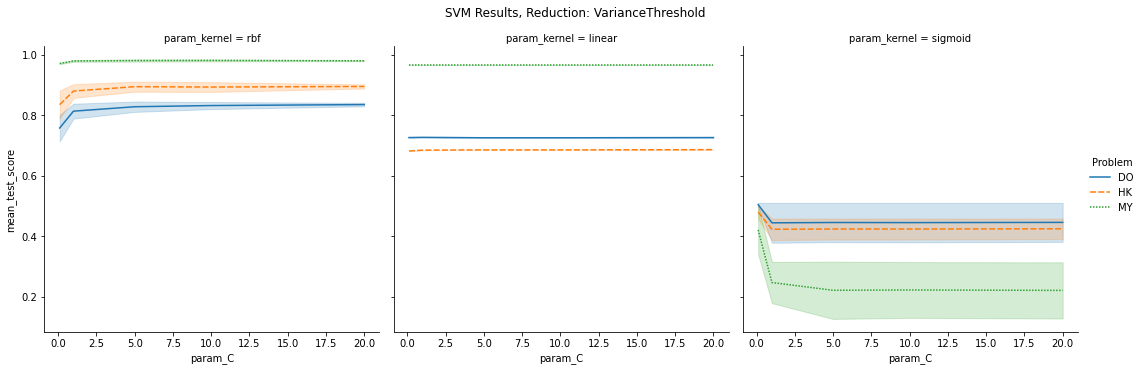

In [698]:
trimmed_SVM_resultsDO
svm_do = trimmed_SVM_resultsDO.assign(Problem='DO')
svm_hk = trimmed_SVM_resultsHK.assign(Problem='HK')
svm_my = trimmed_SVM_resultsMY.assign(Problem='MY')
svm_results = pd.concat([svm_do, svm_hk, svm_my])
svm_results
rp = sns.relplot(
    x="param_C", 
    y="mean_test_score", 
    data=svm_results, 
    col="param_kernel", 
    hue="Problem", 
    style="Problem", 
    kind="line")
rp.fig.subplots_adjust(top=0.87)
rp.fig.suptitle(f'SVM Results, Reduction: {DRType}')

Text(0.5, 0.98, 'KNN Results, Reduction: VarianceThreshold')

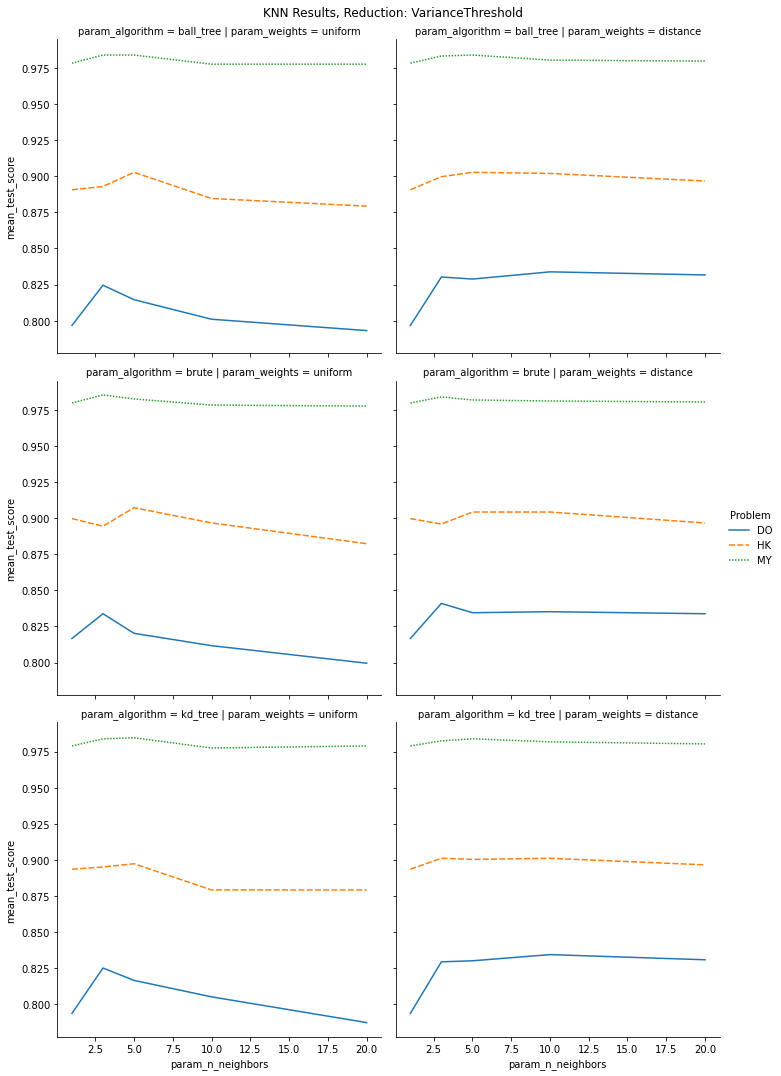

In [699]:
knn_do = trimmed_knn_resultsDO.assign(Problem='DO')
knn_hk = trimmed_knn_resultsHK.assign(Problem='HK')
knn_my = trimmed_knn_resultsMY.assign(Problem='MY')
knn_results = pd.concat([knn_do, knn_hk, knn_my])
knn_results
rp = sns.relplot(
    x="param_n_neighbors", 
    y="mean_test_score", 
    data=knn_results, 
    col="param_weights", 
    row="param_algorithm", 
    hue="Problem", style="Problem", kind="line")
rp.fig.subplots_adjust(top=0.95)
rp.fig.suptitle(f'KNN Results, Reduction: {DRType}')

Text(0.5, 0.98, 'DecisionTree Results, Reduction: VarianceThreshold')

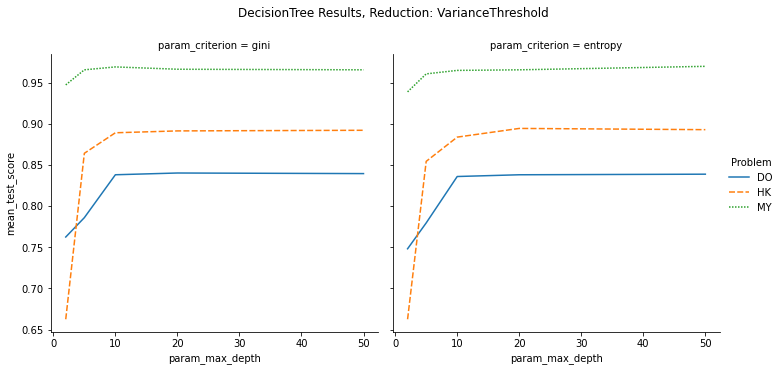

In [700]:
tree_do = trimmed_tree_resultsDO.assign(Problem='DO')
tree_hk = trimmed_tree_resultsHK.assign(Problem='HK')
tree_my = trimmed_tree_resultsMY.assign(Problem='MY')
tree_results = pd.concat([tree_do, tree_hk, tree_my])
rp = sns.relplot(
    x="param_max_depth", 
    y="mean_test_score", 
    data=tree_results, 
    col="param_criterion", 
    hue="Problem", style="Problem", kind="line")
rp.fig.subplots_adjust(top=0.85)
rp.fig.suptitle(f'DecisionTree Results, Reduction: {DRType}')

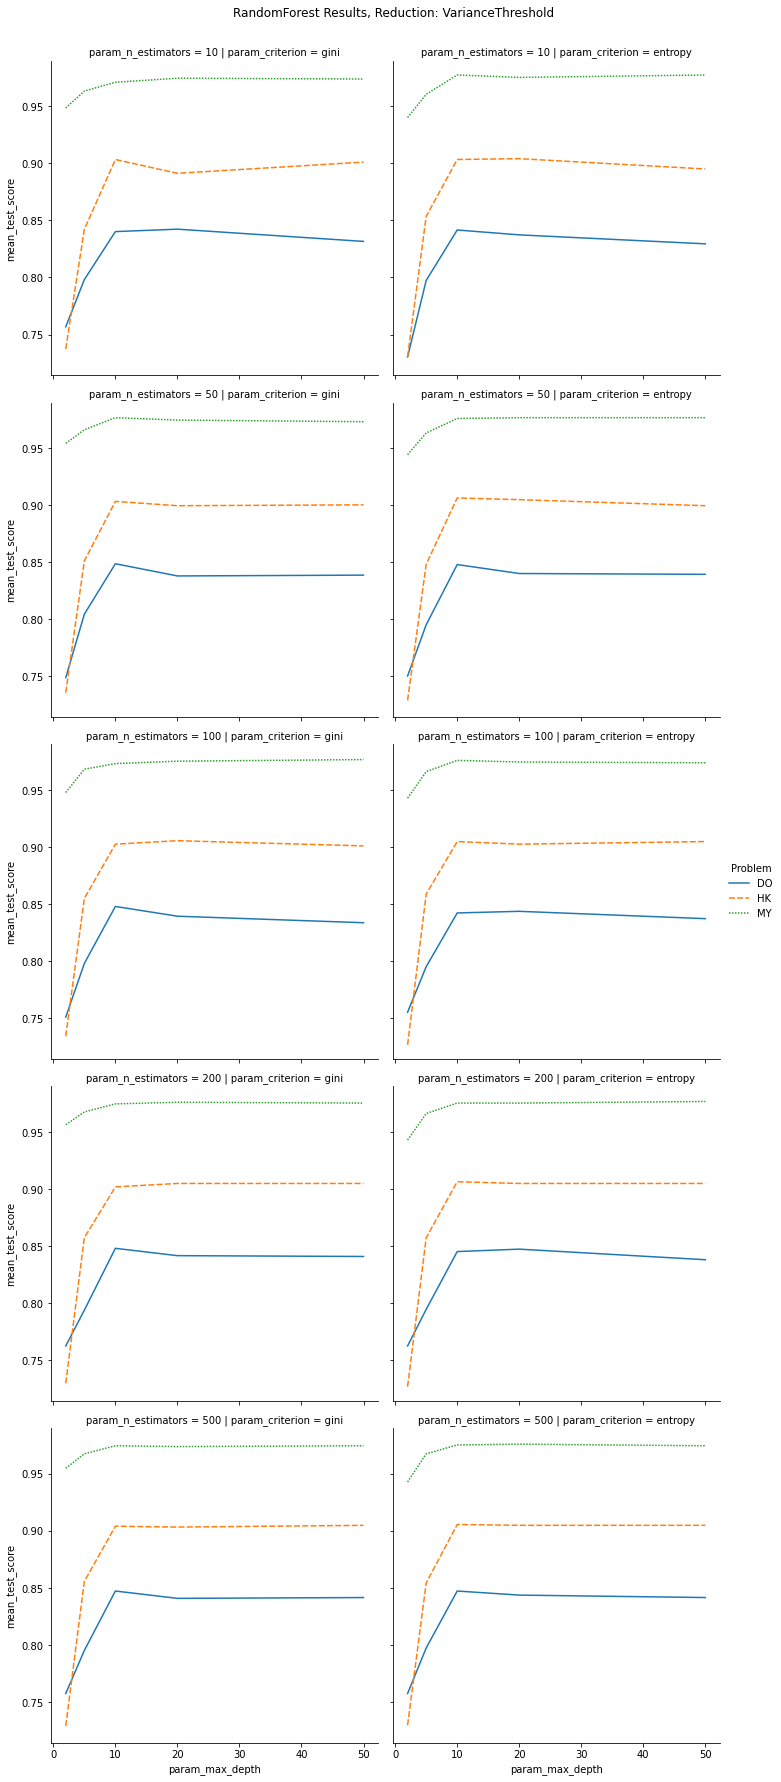

In [701]:
forest_do = trimmed_forest_resultsDO.assign(Problem='DO')
forest_hk = trimmed_forest_resultsHK.assign(Problem='HK')
forest_my = trimmed_forest_resultsMY.assign(Problem='MY')
forest_results = pd.concat([forest_do, forest_hk, forest_my])
forest_results
rp = sns.relplot(
    x="param_max_depth", 
    y="mean_test_score", 
    data=forest_results, 
    col="param_criterion", 
    row="param_n_estimators", 
    hue="Problem", style="Problem", kind="line")
rp.fig.suptitle(f'RandomForest Results, Reduction: {DRType}')
rp.fig.subplots_adjust(top=0.95)

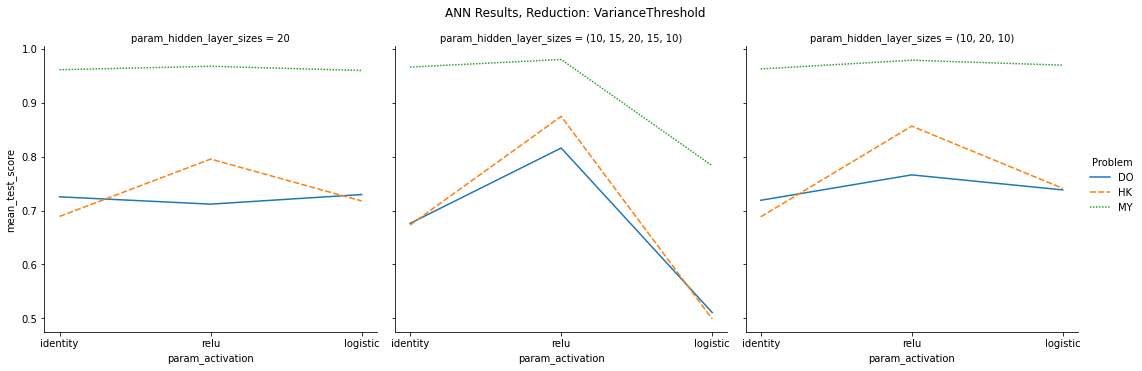

In [702]:
ann_do = trimmed_ann_resultsDO.assign(Problem='DO')
ann_hk = trimmed_ann_resultsHK.assign(Problem='HK')
ann_my = trimmed_ann_resultsMY.assign(Problem='MY')
ann_results = pd.concat([ann_do, ann_hk, ann_my])
ann_results
rp = sns.relplot(
    x="param_activation", 
    y="mean_test_score", 
    data=ann_results, 
    col="param_hidden_layer_sizes", 
    hue="Problem", style="Problem", kind="line")
rp.fig.suptitle(f'ANN Results, Reduction: {DRType}')
rp.fig.subplots_adjust(top=0.87)

## Evaluating Classification of Test Set

In [703]:
trimmed_knn_resultsHK = trimmed_knn_resultsHK.sort_values('mean_test_score', ascending=False)
trimmed_knn_resultsMY = trimmed_knn_resultsMY.sort_values('mean_test_score', ascending=False)
trimmed_knn_resultsDO = trimmed_knn_resultsDO.sort_values('mean_test_score', ascending=False)
knnHK = KNeighborsClassifier(
    n_neighbors = trimmed_knn_resultsHK['param_n_neighbors'][0], 
    weights = trimmed_knn_resultsHK['param_weights'][0],
    algorithm = trimmed_knn_resultsHK['param_algorithm'][0]
)
knnHK.fit(training_X_HK, training_y_HK)

knnMY = KNeighborsClassifier(
    n_neighbors=trimmed_knn_resultsMY['param_n_neighbors'][0], 
    weights=trimmed_knn_resultsMY['param_weights'][0],
    algorithm=trimmed_knn_resultsMY['param_algorithm'][0]
)
knnMY.fit(training_X_MY, training_y_MY)

knnDO = KNeighborsClassifier(
    n_neighbors=trimmed_knn_resultsDO['param_n_neighbors'][0], 
    weights=trimmed_knn_resultsDO['param_weights'][0],
    algorithm=trimmed_knn_resultsDO['param_algorithm'][0]
)
knnDO.fit(training_X_DO, training_y_DO)


start = time.time()
score = knnHK.score(test_X_HK, test_y_HK)
end = time.time()
print(f"Time: {end-start}, Score: {score}")
start = time.time()
score = knnMY.score(test_X_MY, test_y_MY)
end = time.time()
print(f"Time: {end-start}, Score: {score}")
start = time.time()
score = knnDO.score(test_X_DO, test_y_DO)
end = time.time()
print(f"Time: {end-start}, Score: {score}")


Time: 0.003002166748046875, Score: 0.9121621621621622
Time: 0.0040035247802734375, Score: 1.0
Time: 0.003001689910888672, Score: 0.8333333333333334


In [704]:
trimmed_tree_resultsHK = trimmed_tree_resultsHK.sort_values('mean_test_score', ascending=False)
trimmed_tree_resultsMY = trimmed_tree_resultsMY.sort_values('mean_test_score', ascending=False)
trimmed_tree_resultsDO = trimmed_tree_resultsDO.sort_values('mean_test_score', ascending=False)
treeHK = tree.DecisionTreeClassifier(
    criterion=trimmed_tree_resultsHK['param_criterion'][0], 
    max_depth=trimmed_tree_resultsHK['param_max_depth'][0]
)
treeHK.fit(training_X_HK, training_y_HK)

treeMY = tree.DecisionTreeClassifier(
    criterion=trimmed_tree_resultsMY['param_criterion'][0], 
    max_depth=trimmed_tree_resultsMY['param_max_depth'][0]
)
treeMY.fit(training_X_MY, training_y_MY)

treeDO = tree.DecisionTreeClassifier(
    criterion=trimmed_tree_resultsDO['param_criterion'][0], 
    max_depth=trimmed_tree_resultsDO['param_max_depth'][0]
)
treeDO.fit(training_X_DO, training_y_DO)


start = time.time()
score = treeHK.score(test_X_HK, test_y_HK)
end = time.time()
print(f"Time: {end-start}, Score: {score}")
start = time.time()
score = treeMY.score(test_X_MY, test_y_MY)
end = time.time()
print(f"Time: {end-start}, Score: {score}")
start = time.time()
score = treeDO.score(test_X_DO, test_y_DO)
end = time.time()
print(f"Time: {end-start}, Score: {score}")

Time: 0.0, Score: 0.6486486486486487
Time: 0.0010008811950683594, Score: 0.9430379746835443
Time: 0.0, Score: 0.7243589743589743


In [705]:
trimmed_forest_resultsHK = trimmed_forest_resultsHK.sort_values('mean_test_score', ascending=False)
trimmed_forest_resultsMY = trimmed_forest_resultsMY.sort_values('mean_test_score', ascending=False)
trimmed_forest_resultsDO = trimmed_forest_resultsDO.sort_values('mean_test_score', ascending=False)
treesHK = RandomForestClassifier(
    n_estimators=trimmed_forest_resultsHK['param_n_estimators'][0],
    criterion=trimmed_forest_resultsHK['param_criterion'][0], 
    max_depth=trimmed_forest_resultsHK['param_max_depth'][0]
)
treesHK.fit(training_X_HK, training_y_HK)

treesMY = RandomForestClassifier(
    n_estimators=trimmed_forest_resultsMY['param_n_estimators'][0],
    criterion=trimmed_forest_resultsMY['param_criterion'][0], 
    max_depth=trimmed_forest_resultsMY['param_max_depth'][0]
)
treesMY.fit(training_X_MY, training_y_MY)

treesDO = RandomForestClassifier(
    n_estimators=trimmed_forest_resultsDO['param_n_estimators'][0],
    criterion=trimmed_forest_resultsDO['param_criterion'][0], 
    max_depth=trimmed_forest_resultsDO['param_max_depth'][0]
)
treesDO.fit(training_X_DO, training_y_DO)


start = time.time()
score = treesHK.score(test_X_HK, test_y_HK)
end = time.time()
print(f"Time: {end-start}, Score: {score}")
start = time.time()
score = treesMY.score(test_X_MY, test_y_MY)
end = time.time()
print(f"Time: {end-start}, Score: {score}")
start = time.time()
score = treesDO.score(test_X_DO, test_y_DO)
end = time.time()
print(f"Time: {end-start}, Score: {score}")

Time: 0.0010006427764892578, Score: 0.7364864864864865
Time: 0.0010013580322265625, Score: 0.9430379746835443
Time: 0.0020020008087158203, Score: 0.6474358974358975


In [706]:
trimmed_svm_resultsHK = trimmed_SVM_resultsHK.sort_values('mean_test_score', ascending=False)
trimmed_svm_resultsMY = trimmed_SVM_resultsMY.sort_values('mean_test_score', ascending=False)
trimmed_svm_resultsDO = trimmed_SVM_resultsDO.sort_values('mean_test_score', ascending=False)
svmHK = svm.SVC(
    C=trimmed_svm_resultsHK['param_C'][0],
    kernel=trimmed_svm_resultsHK['param_kernel'][0], 
    gamma=trimmed_svm_resultsHK['param_gamma'][0]
)
svmHK.fit(training_X_HK, training_y_HK)

svmMY = svm.SVC(
    C=trimmed_svm_resultsMY['param_C'][0],
    kernel=trimmed_svm_resultsMY['param_kernel'][0], 
    gamma=trimmed_svm_resultsMY['param_gamma'][0]
)
svmMY.fit(training_X_MY, training_y_MY)

svmDO = svm.SVC(
    C=trimmed_svm_resultsDO['param_C'][0],
    kernel=trimmed_svm_resultsDO['param_kernel'][0], 
    gamma=trimmed_svm_resultsDO['param_gamma'][0]
)
svmDO.fit(training_X_DO, training_y_DO)


start = time.time()
score = svmHK.score(test_X_HK, test_y_HK)
end = time.time()
print(f"Time: {end-start}, Score: {score}")

start = time.time()
score = svmMY.score(test_X_MY, test_y_MY)
end = time.time()
print(f"Time: {end-start}, Score: {score}")

start = time.time()
score = svmDO.score(test_X_DO, test_y_DO)
end = time.time()
print(f"Time: {end-start}, Score: {score}")

Time: 0.007006645202636719, Score: 0.8783783783783784
Time: 0.0050046443939208984, Score: 0.9810126582278481
Time: 0.008007049560546875, Score: 0.7884615384615384


In [707]:
trimmed_ann_resultsHK = trimmed_ann_resultsHK.sort_values('mean_test_score', ascending=False)
trimmed_ann_resultsMY = trimmed_ann_resultsMY.sort_values('mean_test_score', ascending=False)
trimmed_ann_resultsDO = trimmed_ann_resultsDO.sort_values('mean_test_score', ascending=False)
annHK = MLPClassifier(
    hidden_layer_sizes=trimmed_ann_resultsHK['param_hidden_layer_sizes'][0],
    activation=trimmed_ann_resultsHK['param_activation'][0]
)
annHK.fit(training_X_HK, training_y_HK)

annMY = MLPClassifier(
    hidden_layer_sizes=trimmed_ann_resultsMY['param_hidden_layer_sizes'][0],
    activation=trimmed_ann_resultsMY['param_activation'][0]
)
annMY.fit(training_X_MY, training_y_MY)

annDO = MLPClassifier(
    hidden_layer_sizes=trimmed_ann_resultsDO['param_hidden_layer_sizes'][0],
    activation=trimmed_ann_resultsDO['param_activation'][0]
)
annDO.fit(training_X_DO, training_y_DO)


start = time.time()
score = annHK.score(test_X_HK, test_y_HK)
end = time.time()
print(f"Time: {end-start}, Score: {score}")

start = time.time()
score = annMY.score(test_X_MY, test_y_MY)
end = time.time()
print(f"Time: {end-start}, Score: {score}")

start = time.time()
score = annDO.score(test_X_DO, test_y_DO)
end = time.time()
print(f"Time: {end-start}, Score: {score}")

Time: 0.0010008811950683594, Score: 0.6959459459459459
Time: 0.0, Score: 0.9683544303797469
Time: 0.0010008811950683594, Score: 0.6282051282051282


C:\Users\Joshua\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
